# This notebook is for demonstrating a Bayesian workflow with a simple SEIR epidemiological model toy problem

### Load dependencies

In [1]:
import os
import json
import requests
import sympy
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Dict, List, Callable

# MIRA modeling dependencies
from mira.metamodel import *
from mira.metamodel.ops import stratify
from mira.examples.concepts import susceptible, exposed, infected, recovered
from mira.modeling import Model
from mira.modeling.amr.petrinet import AMRPetriNetModel, template_model_to_petrinet_json
from mira.sources.amr.petrinet import template_model_from_amr_json
from mira.metamodel.io import model_to_json_file, model_from_json_file

# PyCIEMSS dependencies
import pyciemss
import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories
from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)

# Build SEIR model with MIRA

### Define units

In [2]:
person_units = lambda: Unit(expression=sympy.Symbol('person'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))

### Define model concepts

In [3]:
c = {
    "S": Concept(name="S", units=person_units(), identifiers={"ido": "0000514"}), # susceptible
    "E": Concept(name="E", units=person_units(), identifiers={"apollosv": "0000154"}), # exposed
    "I": Concept(name="I", units=person_units(), identifiers={"ido": "0000511"}), # infectious
    "R": Concept(name="R", units=person_units(), identifiers={"ido": "0000592"}), # recovered
}

for concept in c:
    c[concept].name = concept

### Define model parameters with uncertainty

In [4]:
total_population = 100_000.0
I0_guess = 20

parameters = {
    'beta': Parameter(name='beta', value=sympy.Float(0.3), units=per_day_units(),
                      distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.28,
                                                            'maximum': 0.32})),  # Transmission rate S -> E by contact with I

    'N': Parameter(name='N', value=sympy.Float(total_population), units=dimensionless_units()),  # Total population

    'I0': Parameter(name='I0', value=sympy.Float(I0_guess), units=per_day_units(),
                     distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.9*I0_guess,
                                                            'maximum': 1.1*I0_guess})),  # Initial infectious population
    
    'sigma': Parameter(name='sigma', value=sympy.Float(0.25), units=per_day_units()),  # Rate of progressing E -> I
    
    'gamma': Parameter(name='gamma', value=sympy.Float(0.14), units=per_day_units(),
                     distribution=Distribution(type='StandardUniform1',
                                                parameters={'minimum': 0.1,
                                                            'maximum': 0.2})),  # Rate of progressing I -> R
}

### Define `SymPy` symbols

In [5]:
S, E, I, R, beta, N, I0, sigma, gamma = sympy.symbols('S E I R beta N I0 sigma gamma')

### Set initial conditions

In [6]:
initials = {
    "S": Initial(concept=c["S"], expression=total_population - I0),
    "E": Initial(concept=c["E"], expression=3*I0),
    "I": Initial(concept=c["I"], expression=I0),
    "R": Initial(concept=c["R"], expression=0),
}

### Define model templates

In [7]:
##### S -> E
se = ControlledConversion(
    subject=c['S'],
    outcome=c['E'],
    controller=c['I'],
    rate_law=beta*S*I/N
)


#### E -> I
ei = NaturalConversion(
    subject=c['E'],
    outcome=c['I'],
    rate_law=sigma*E
)


#### I -> R
ir = NaturalConversion(
    subject=c['I'],
    outcome=c['R'],
    rate_law=gamma*I
)

### Define template model and save as petrinet AMR

In [8]:
seir_model = TemplateModel(
    templates=[
        se,
        ei,
        ir
    ],
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=[],
    annotations=Annotations(name='SEIR base model')
)

# Save as JSON
with open("seir_model.json", 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model), fh, indent=1)

# Run the model with `PyCIEMSS`

### Set model path and parameters for sampling

In [9]:
model = "seir_model.json"
num_samples = 1000
start_time = 0.0
end_time = 180.0
logging_step_size = 1.0

## Sample from model prior and plot the result

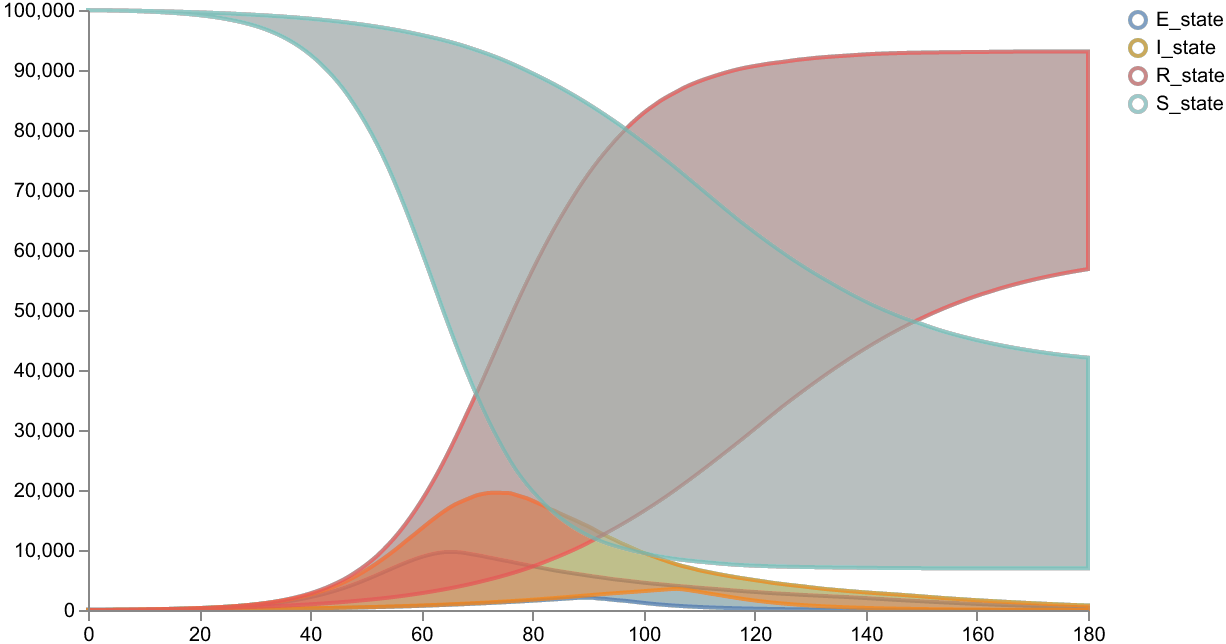

In [10]:
result = pyciemss.sample(model, end_time, logging_step_size, num_samples, start_time=start_time)
# display(result1['data'].head())

# Plot results for all states
schema = plots.trajectories(result["data"], keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

## Generate synthetic data

### Remove uncertainty from transmission rate `beta`, recovery rate `gamma`, and intial infectious population `I0`

In [11]:
print(f"beta value: {seir_model.parameters['beta'].value}")
beta_const_value = seir_model.parameters['beta'].value
print(f"beta prior distribution: {seir_model.parameters['beta'].distribution}")
beta_prior_min = seir_model.parameters['beta'].distribution.parameters["minimum"]
beta_prior_max = seir_model.parameters['beta'].distribution.parameters["maximum"]
seir_model.parameters['beta'].distribution = None

print(f"gamma value: {seir_model.parameters['gamma'].value}")
gamma_const_value = seir_model.parameters['gamma'].value
print(f"gamma prior distribution: {seir_model.parameters['gamma'].distribution}")
gamma_prior_min = seir_model.parameters['gamma'].distribution.parameters["minimum"]
gamma_prior_max = seir_model.parameters['gamma'].distribution.parameters["maximum"]
seir_model.parameters['gamma'].distribution = None

print(f"I0 value: {seir_model.parameters['I0'].value}")
I0_const_value = seir_model.parameters['I0'].value
print(f"I0 prior distribution: {seir_model.parameters['I0'].distribution}")
I0_prior_min = seir_model.parameters['I0'].distribution.parameters["minimum"]
I0_prior_max = seir_model.parameters['I0'].distribution.parameters["maximum"]
seir_model.parameters['I0'].distribution = None

# Save as updated AMR
with open('seir_model_constant_params.json', 'w') as fh:
    json.dump(template_model_to_petrinet_json(seir_model), fh, indent=1)

beta value: 0.3
beta prior distribution: type='StandardUniform1' parameters={'minimum': 0.28, 'maximum': 0.32}
gamma value: 0.14
gamma prior distribution: type='StandardUniform1' parameters={'minimum': 0.1, 'maximum': 0.2}
I0 value: 20.0
I0 prior distribution: type='StandardUniform1' parameters={'minimum': 18.0, 'maximum': 22.0}


### Take a single sample from the model with uncertainty removed

,timepoint_id,sample_id,timepoint_unknown,persistent_N_param,persistent_beta_param,persistent_sigma_param,persistent_gamma_param,persistent_I0_param,S_state,I_state,E_state,R_state
0,0,0,0.0,100000.0,0.3,0.25,0.14,20.0,99980.000000,20.000000,60.000000,0.000000
1,1,0,1.0,100000.0,0.3,0.25,0.14,20.0,99972.343750,30.523310,53.557697,3.572463
2,2,0,2.0,100000.0,0.3,0.25,0.14,20.0,99961.921875,38.662006,50.974091,8.436172
3,3,0,3.0,100000.0,0.3,0.25,0.14,20.0,99949.289062,45.456261,50.916489,14.335662
4,4,0,4.0,100000.0,0.3,0.25,0.14,20.0,99934.726562,51.565529,52.566391,21.132317


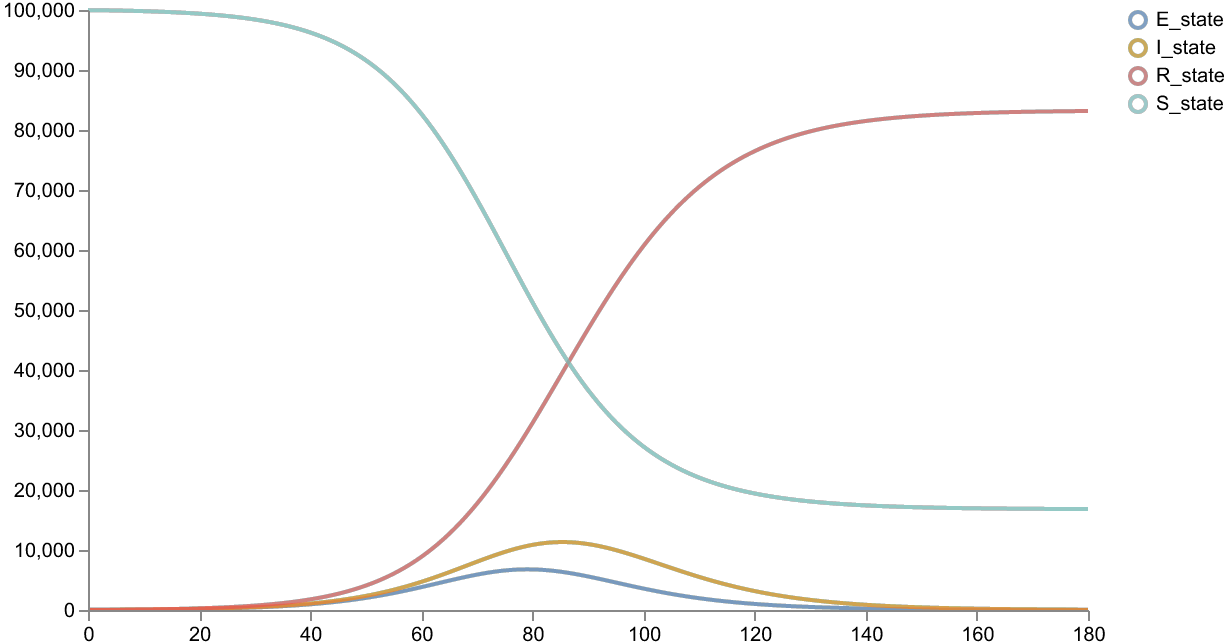

In [12]:
const_param_model = 'seir_model_constant_params.json'
result1 = pyciemss.sample(const_param_model, end_time, logging_step_size, 1, start_time=start_time)
display(result1['data'].head())

# Plot results for all states
schema = plots.trajectories(result1["data"], keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Add Gaussian and uniformly distributed noise to simulated result for `I` and `R` states

In [13]:
# Uniform noise: U(0.9 * value, 1.1 * value)
df_uniform = result1['data'].copy()
df_uniform['I_state'] = df_uniform['I_state'] * np.random.uniform(0.9, 1.1, df_uniform['I_state'].shape)
df_uniform['R_state'] = df_uniform['R_state'] * np.random.uniform(0.9, 1.1, df_uniform['R_state'].shape)

# Make sure all values are positive and round to nearest decimal
df_uniform['I_state'] = df_uniform['I_state'].abs().round(1)
df_uniform['R_state'] = df_uniform['R_state'].abs().round(1)

# Keep data to time 60
df_uniform = df_uniform.iloc[:61]

# Create the new dataframe for uniform noise
uniform_df = pd.DataFrame({
    'Timestamp': df_uniform['timepoint_unknown'],
    'I_data': df_uniform['I_state'],
    'R_data': df_uniform['R_state']
})

# Gaussian noise: N(mean = value, standard_deviation = 0.1 * value)
df_gaussian = result1['data'].copy()
df_gaussian['I_state'] = df_gaussian['I_state'] + np.random.normal(0, 0.1 * df_gaussian['I_state'], df_gaussian['I_state'].shape)
df_gaussian['R_state'] = df_gaussian['R_state'] + np.random.normal(0, 0.1 * df_gaussian['R_state'], df_gaussian['R_state'].shape)

# Make sure all values are positive and round to nearest decimal
df_gaussian['I_state'] = df_gaussian['I_state'].abs().round(1)
df_gaussian['R_state'] = df_gaussian['R_state'].abs().round(1)

# Keep data to time 60
df_gaussian = df_gaussian.iloc[:61]

# Create the new dataframe for Gaussian noise
gaussian_df = pd.DataFrame({
    'Timestamp': df_gaussian['timepoint_unknown'],
    'I_data': df_gaussian['I_state'],
    'R_data': df_gaussian['R_state']
})

# Save synthetic data
uniform_df.to_csv('seir_synth_data_unif.csv', index=False)
gaussian_df.to_csv('seir_synth_data_gaussian.csv', index=False)

### Calibrate original model (with uncertainty) to synthetic data with Gaussian noise

In [14]:
# dataset = 'seir_synth_data_gaussian.csv'
# data_mapping = {'I_data': 'I', 'R_data': 'R'}
# num_iterations = 500

# calibrated_result = pyciemss.calibrate(model, dataset, data_mapping=data_mapping, num_iterations=num_iterations)
# parameter_estimates = calibrated_result["inferred_parameters"]
# # display(parameter_estimates())
    
# calibrated_sample_result1 = pyciemss.sample(model, end_time, logging_step_size, num_samples, 
#                                                 start_time=start_time, inferred_parameters=parameter_estimates)
# display(calibrated_sample_result1['data'].head())

# # Plot calibrated result
# data_df = pd.read_csv(dataset)
# schema = plots.trajectories(
#     calibrated_sample_result1["data"], 
#     keep=".*_state", 
#     points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
# )
# plots.save_schema(schema, "_schema.json")
# plots.ipy_display(schema, dpi=150)

### Plot prior and calibrated parameter distributions

In [15]:
# # Extract unique values for each parameter
# unique_beta_params = calibrated_sample_result1['data'][['sample_id', 'persistent_beta_param']].drop_duplicates()['persistent_beta_param']
# unique_gamma_params = calibrated_sample_result1['data'][['sample_id', 'persistent_gamma_param']].drop_duplicates()['persistent_gamma_param']
# unique_I0_params = calibrated_sample_result1['data'][['sample_id', 'persistent_I0_param']].drop_duplicates()['persistent_I0_param']

# # Set up the plotting grid
# fig, axs = plt.subplots(1, 3, figsize=(14, 6))

# # Histogram of beta values
# sns.histplot(unique_beta_params, kde=False, color='blue', bins=30, label='Calibrated beta', alpha=0.6, ax=axs[0])
# axs[0].axvline(x=beta_const_value, color='black', linestyle='--', linewidth=2, label='True beta')
# axs[0].axvline(x=beta_prior_min, color='black', linestyle='-', linewidth=2.5, label='Uniform prior lower bd.')
# axs[0].axvline(x=beta_prior_max, color='black', linestyle='-', linewidth=2.5, label='Uniform prior upper bd.')
# axs[0].set_xlabel('Beta values')
# axs[0].set_ylabel('Frequency')
# axs[0].set_title('Calibrated beta vs prior estimate')
# axs[0].legend()

# # Histogram of gamma values
# sns.histplot(unique_gamma_params, kde=False, color='blue', bins=30, label='Calibrated gamma', alpha=0.6, ax=axs[1])
# axs[1].axvline(x=gamma_const_value, color='black', linestyle='--', linewidth=2, label='True gamma')
# axs[1].axvline(x=gamma_prior_min, color='black', linestyle='-', linewidth=2.5, label='Uniform prior lower bd.')
# axs[1].axvline(x=gamma_prior_max, color='black', linestyle='-', linewidth=2.5, label='Uniform prior upper bd.')
# axs[1].set_xlabel('Gamma values')
# axs[1].set_ylabel('Frequency')
# axs[1].set_title('Calibrated gamma vs prior estimate')
# axs[1].legend()

# # Histogram of I0 values
# sns.histplot(unique_I0_params, kde=False, color='blue', bins=30, label='Calibrated I0', alpha=0.6, ax=axs[2])
# axs[2].axvline(x=I0_const_value, color='black', linestyle='--', linewidth=2, label='True I0')
# axs[2].axvline(x=I0_prior_min, color='black', linestyle='-', linewidth=2.5, label='Uniform prior lower bd.')
# axs[2].axvline(x=I0_prior_max, color='black', linestyle='-', linewidth=2.5, label='Uniform prior upper bd.')
# axs[2].set_xlabel('I0 values')
# axs[2].set_ylabel('Frequency')
# axs[2].set_title('Calibrated I0 vs prior estimate')
# axs[2].legend()

# # Show plot
# plt.show()

### Calibrate original model (with uncertainty) to synthetic data with uniformly distributed noise

/Users/altu809/Projects/pyciemss/pyciemss/integration_utils/observation.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data_df.applymap(lambda x: isinstance(x, (int, float))).all().all():


Data printout: This dataset contains 60 rows of data. The first column, Timestamp, begins at 0.0 and ends at 60.0. The subsequent columns are named: I_data, R_data


,timepoint_id,sample_id,timepoint_unknown,persistent_beta_param,persistent_gamma_param,persistent_I0_param,persistent_N_param,persistent_sigma_param,S_state,I_state,E_state,R_state
0,0,0,0.0,0.301094,0.14216,19.443506,100000.0,0.25,99980.554688,19.443506,58.330521,0.000000
1,1,0,1.0,0.301094,0.14216,19.443506,100000.0,0.25,99973.101562,29.626095,52.085346,3.523365
2,2,0,2.0,0.301094,0.14216,19.443506,100000.0,0.25,99962.898438,37.481888,49.582111,8.313946
3,3,0,3.0,0.301094,0.14216,19.443506,100000.0,0.25,99950.625000,44.024403,49.523876,14.118560
4,4,0,4.0,0.301094,0.14216,19.443506,100000.0,0.25,99936.609375,49.894787,51.114521,20.799395


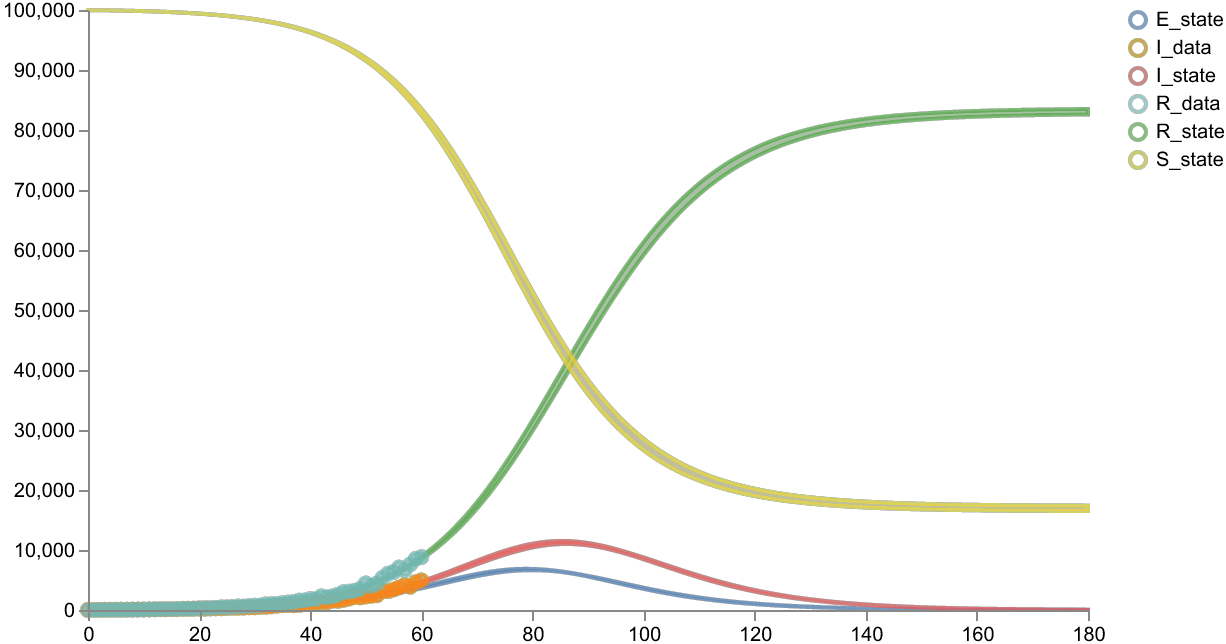

In [16]:
dataset = 'seir_synth_data_unif.csv'
data_mapping = {'I_data': 'I', 'R_data': 'R'}
num_iterations = 500

calibrated_result = pyciemss.calibrate(model, dataset, data_mapping=data_mapping, num_iterations=num_iterations)
parameter_estimates = calibrated_result["inferred_parameters"]
# display(parameter_estimates())
    
calibrated_sample_result2 = pyciemss.sample(model, end_time, logging_step_size, num_samples, 
                                                start_time=start_time, inferred_parameters=parameter_estimates)
display(calibrated_sample_result2['data'].head())

# Plot calibrated result
data_df = pd.read_csv(dataset)
schema = plots.trajectories(
    calibrated_sample_result2["data"], 
    keep=".*_state", 
    points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

### Plot prior and calibrated parameter distributions

/Users/altu809/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/altu809/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/altu809/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


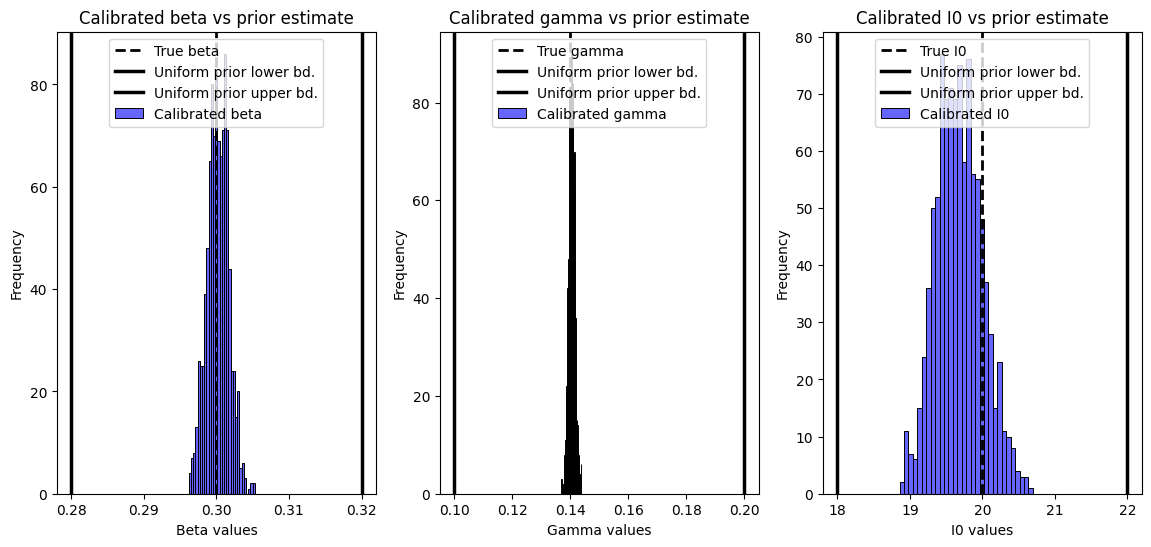

In [17]:
# Extract unique values for each parameter
unique_beta_params = calibrated_sample_result2['data'][['sample_id', 'persistent_beta_param']].drop_duplicates()['persistent_beta_param']
unique_gamma_params = calibrated_sample_result2['data'][['sample_id', 'persistent_gamma_param']].drop_duplicates()['persistent_gamma_param']
unique_I0_params = calibrated_sample_result2['data'][['sample_id', 'persistent_I0_param']].drop_duplicates()['persistent_I0_param']

# Set up the plotting grid
fig, axs = plt.subplots(1, 3, figsize=(14, 6))

# Histogram of beta values
sns.histplot(unique_beta_params, kde=False, color='blue', bins=30, label='Calibrated beta', alpha=0.6, ax=axs[0])
axs[0].axvline(x=beta_const_value, color='black', linestyle='--', linewidth=2, label='True beta')
axs[0].axvline(x=beta_prior_min, color='black', linestyle='-', linewidth=2.5, label='Uniform prior lower bd.')
axs[0].axvline(x=beta_prior_max, color='black', linestyle='-', linewidth=2.5, label='Uniform prior upper bd.')
axs[0].set_xlabel('Beta values')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Calibrated beta vs prior estimate')
axs[0].legend()

# Histogram of gamma values
sns.histplot(unique_gamma_params, kde=False, color='blue', bins=30, label='Calibrated gamma', alpha=0.6, ax=axs[1])
axs[1].axvline(x=gamma_const_value, color='black', linestyle='--', linewidth=2, label='True gamma')
axs[1].axvline(x=gamma_prior_min, color='black', linestyle='-', linewidth=2.5, label='Uniform prior lower bd.')
axs[1].axvline(x=gamma_prior_max, color='black', linestyle='-', linewidth=2.5, label='Uniform prior upper bd.')
axs[1].set_xlabel('Gamma values')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Calibrated gamma vs prior estimate')
axs[1].legend()

# Histogram of I0 values
sns.histplot(unique_I0_params, kde=False, color='blue', bins=30, label='Calibrated I0', alpha=0.6, ax=axs[2])
axs[2].axvline(x=I0_const_value, color='black', linestyle='--', linewidth=2, label='True I0')
axs[2].axvline(x=I0_prior_min, color='black', linestyle='-', linewidth=2.5, label='Uniform prior lower bd.')
axs[2].axvline(x=I0_prior_max, color='black', linestyle='-', linewidth=2.5, label='Uniform prior upper bd.')
axs[2].set_xlabel('I0 values')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Calibrated I0 vs prior estimate')
axs[2].legend()

# Show plot
plt.show()

## Intervene on transmission rate

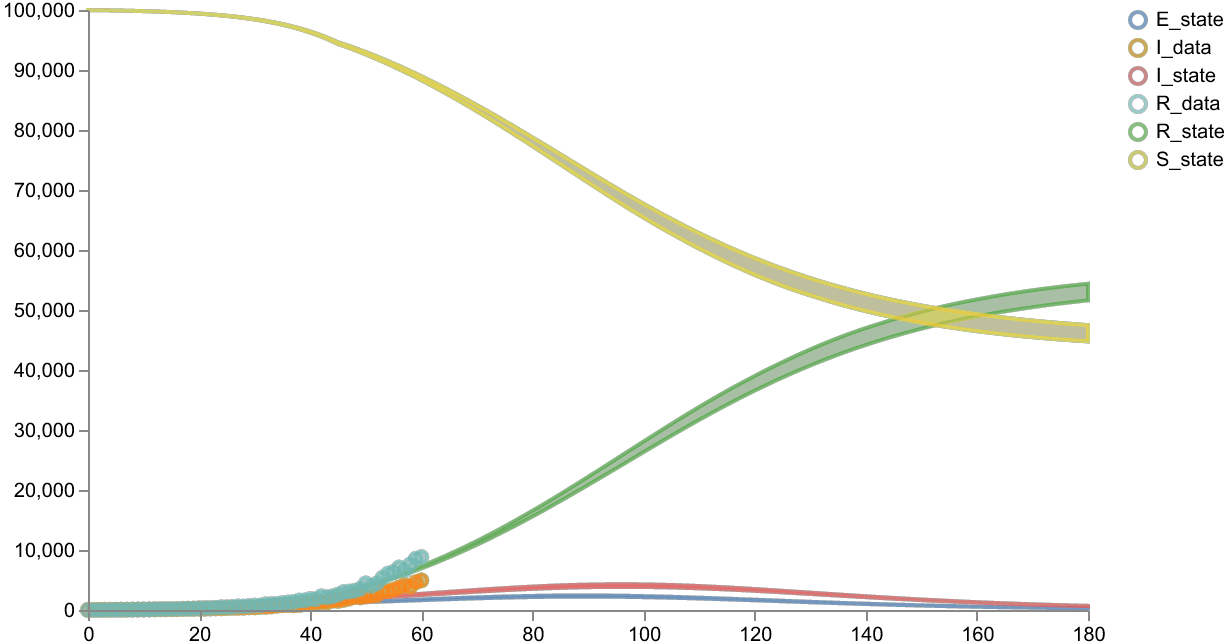

In [18]:
# Decrease the transmission rate to 0.2 after 45 days
intervened_sample_results1 = pyciemss.sample(
    model, end_time, logging_step_size, num_samples, start_time=start_time, 
    inferred_parameters=parameter_estimates,
    static_parameter_interventions = {torch.tensor(45.0): {"beta": torch.tensor(0.2)}}
)

# Plot result
data_df = pd.read_csv(dataset)
schema = plots.trajectories(
    intervened_sample_results1["data"], 
    keep=".*_state", 
    points=data_df.drop(columns=['Timestamp']).reset_index(drop=True)
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

# Optimization under uncertainty

Find the minimal change in transmission rate `beta` at 30 days such that the infectious population does not exceed 5,000

### Set up optimization and define QoI

In [19]:
from pyciemss.ouu.qoi import obs_max_qoi, obs_nday_average_qoi

num_samples_ouu = 1000 # controls accuracy of risk estimation in each optimization iteration
maxiter = 50 # maximum number of restarts of local convex optimizer leading to maxiter + 1 local optimizations
maxfeval = 100 # maximum number of function evaluations in each instance of local convex optimization

### Run optimization for `beta`

In [20]:
# Define optimization problem setup
observed_params = ["I_state"]
intervention_time = [torch.tensor(30.0)]
intervened_params = ["beta"]
current_param_value = beta_const_value
initial_guess_interventions = 0.25
bounds_interventions = [[0.1], [beta_const_value + 0.01]]
static_parameter_interventions = param_value_objective(
    param_name = intervened_params,
    param_value = [lambda x: torch.tensor(x)],
    start_time = intervention_time,
)

# Keep infections below 5_000
risk_bound = 5_000.0
qoi = lambda y: obs_max_qoi(y, observed_params)

objfun = lambda x: np.abs(current_param_value - x)

# Run optimize interface
opt_result1 = pyciemss.optimize(
    model,
    end_time,
    logging_step_size,
    qoi,
    risk_bound,
    static_parameter_interventions,
    objfun,
    initial_guess_interventions=initial_guess_interventions,
    bounds_interventions=bounds_interventions,
    start_time=start_time,
    inferred_parameters=parameter_estimates,
    n_samples_ouu=num_samples_ouu,
    maxiter=maxiter,
    maxfeval=maxfeval,
)

print(f'Optimal policy:', opt_result1["policy"])
print(opt_result1)

/Users/altu809/Projects/pyciemss/pyciemss/ouu/ouu.py:107: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/altu809/Projects/pyciemss/pyciemss/ouu/ouu.py:107: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/altu809/Projects/pyciemss/pyciemss/ouu/ouu.py:107: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/altu809/Projects/pyciemss/pyciemss/ouu/ouu.py:107: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/altu809/Projects/pyciemss/pyciemss/ouu/ouu.py:107: UserWarning: Selected interventions are out of bounds. Will use a penalty instead of estimating risk.
  warnings.warn(
/Users/altu809/Projects/pyciemss/pyciemss/ouu/ouu.py:107: UserWarning: Selected interventions are out of bounds. Wi

Optimal policy: tensor([0.2161], dtype=torch.float64)
{'policy': tensor([0.2161], dtype=torch.float64), 'OptResults':                     message: ['requested number of basinhopping iterations completed successfully']
                    success: True
                        fun: 0.08390544188311325
                          x: [ 2.161e-01]
                        nit: 50
      minimization_failures: 27
                       nfev: 471
 lowest_optimization_result: message: Optimization terminated successfully.
                             success: True
                              status: 1
                                 fun: 0.08390544188311325
                                   x: [ 2.161e-01]
                                nfev: 7
                               maxcv: 0.0}


### Sample with optimal intervention applied and plot the result

Intervention:  {30.0: {'beta': tensor([0.2161])}}
Risk associated with QoI: [1021.6357873535156]


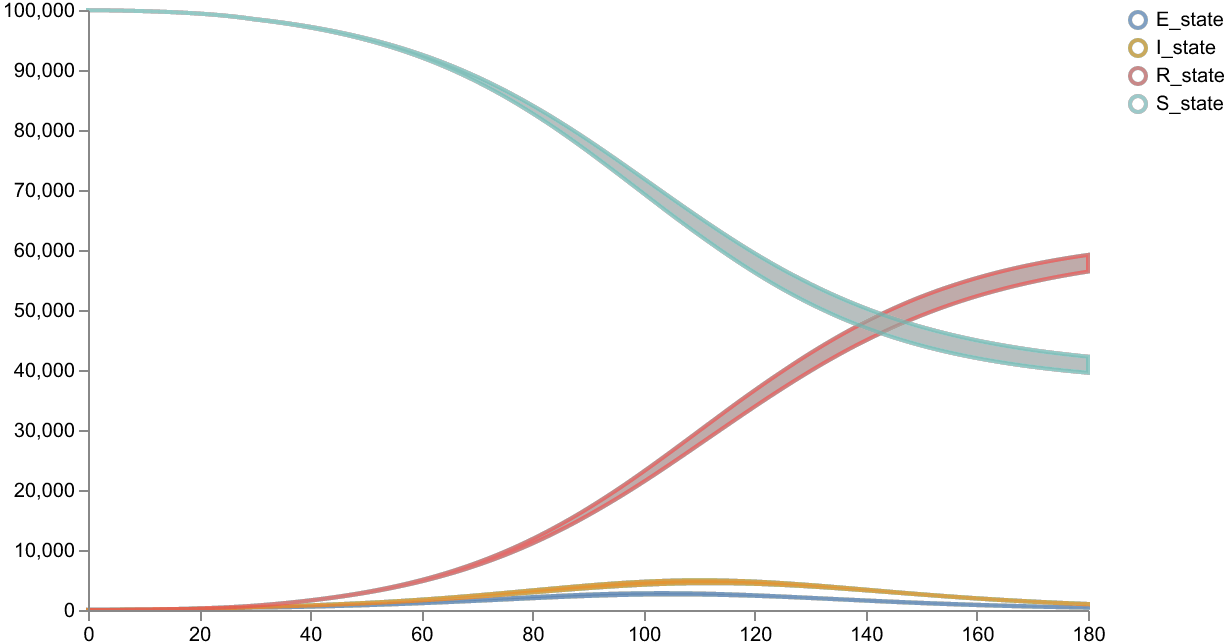

In [21]:
print("Intervention: ", static_parameter_interventions(opt_result1["policy"]))

opt_intervention_result1 = pyciemss.sample(
    model,
    end_time,
    logging_step_size,
    num_samples,
    start_time=start_time,
    inferred_parameters=parameter_estimates,
    static_parameter_interventions=static_parameter_interventions(opt_result1["policy"]),
)

# display(result1["data"])
print("Risk associated with QoI:", opt_intervention_result1["risk"][observed_params[0]]["risk"])

# Plot result
schema = plots.trajectories(
    opt_intervention_result1["data"], 
    keep=".*_state", 
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

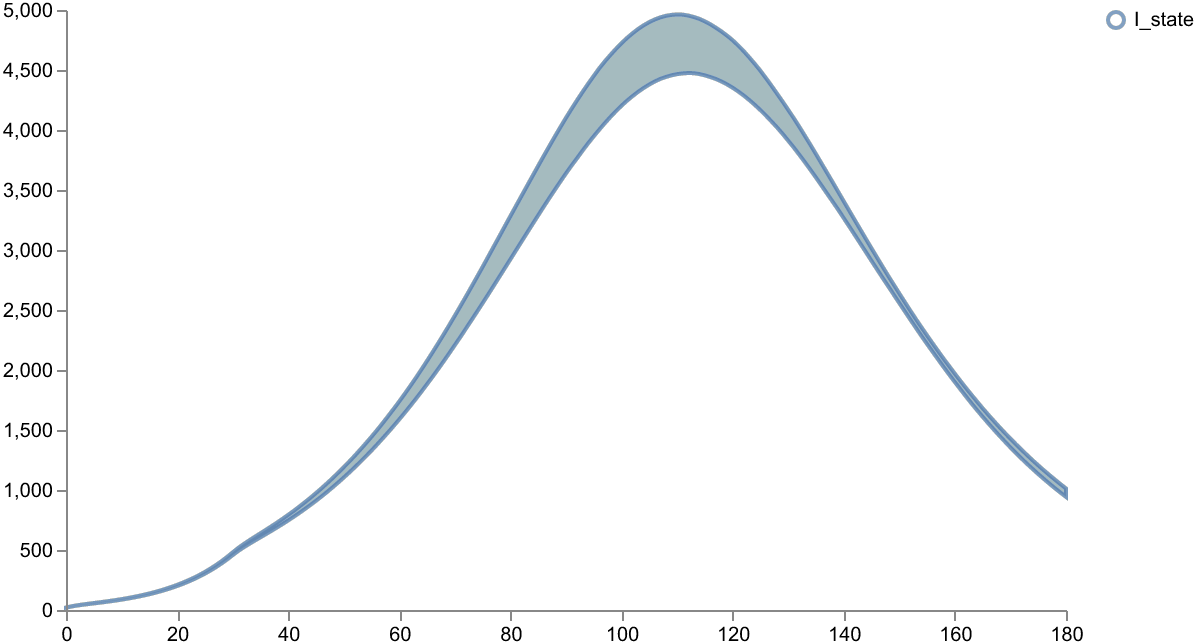

In [22]:
# Plot result for I state
schema = plots.trajectories(
    opt_intervention_result1["data"], 
    keep="I_state", 
)
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)